# Autoencoders for anomaly detection in Oxford Nanopore Technology direct RNA-Sequencing: identification of modified nucleotides.

**Author:** Adriano Fonzino, Ph.D.

## 1.0. Introduction
Recently, many efforts have been sustained in order improve our ability to identify and map RNA modifications. These have been mainly focused on the use of next generation sequencing techniques. These platforms are, however, usually blind to nucleotides modification since they require a cDNA library preparation steps that masks base modifications. Furthermore, these are only indirect detection methods, without a univoque starndard and generic approach to retrieve the position and presence of RNA modifications at single base resolutions. Some protocols expect the use of specific antibotidies to recognize modifications or the use of chemical pretreatments (also in-vivo) with substances able to react specifically with modified bases. The incredible amount of RNA modifications (more than 150 at least) is not suitable to be harnessed easely only with this approaches since these are bound to the availability of both specific antibodies and chemical reagents. <br>

In this context Oxford Nanopore Technology (ONT) could play a pivotal role as game changer in the field of direct RNA sequencing and RNA/DNA modification detection. ONT is a company founded in 2005 as a spin-out from the University of Oxford. They produced a set of technologies used for single-molecule, long-read sequencing of DNA and RNA sequence. ONT sequencing is based on the use of a membrane with an array of nanopores, where the polynucleotide chain pass through generating a ionic current change since the voltage is "clamped" across the two side of the flowcell.

ONT is labelled, together with Pacific Biosciences (PacBio) instruments, as third-generation sequencing technologies and have been recently purposed as new tool for the dection of RNA modifications in native RNA sequences. It allowed, also thanks new protocols, the sequencing of direct-RNA single-molecules without the need of the intermediate cDNA library construction step. This ONT feature is very important and promising since it gives the possibility to preserve the nucleotide modifications as well.
In a nutshell, when modified nucleotides are present into the sequenced molecule, they cause a disruption of the ionic current across the pore that can be potentially identified by comparing raw current signals, known as "squiggle". Today, the main tool that tries to perform this inference is **Tombo**, a deep learning based algoritmh that requires a challeging step of re-squiggling and alignment of the current intensities and that it is "only" focused on m6A and m5C modifications at the moment.
Recently, in an article published on Nature Communications in the 2019 by Liu et al., researchers trained a Support Vector Machine (SVM) classifier that is able to predict modified m6A nucleotides into ONT native RNA-sequencing experiments basing on the "errors" that basecallers usually make when encounter base modifications. Thus, they understood and demonstrated that, basecallers "errors" can be interpretated as putative presence of a RNA modifications. They used an *in-vitro* transcribed 10kb-long artificial sequence to evaluate this aspect. The sequence, called here "curlcake" (from the software's name, used to produce it), contains all the possible combinations among the 4 nucleotides (A, C, G, U/T) in a kmer of length 5. They created two samples, one synthetized in presence of m6A-mofified nucleotides, and the other in absence of these as control, used to train the SVM model. Researchers called the model **EpiNano**. Results where confirmed by experiments using enginnered knock-out Yeasts not able to catalize m6A related reactions. The algoritmh were able to predict m6A modifications with a good degree of accuracy (about 90%). One of the limitations of EpiNano is the need of both control and modified samples to makes predictions.

This model can be obviously improved and put the basis of the experiment of this notebook. If both Tombo and EpiNano are able to predict RNA modifications basing on raw signals and basecallers errors, respectively, it means that probably, informations about the precence of modified nucleotides are embedded inside the raw signal of the ONT instrumentation. Tombo and EpiNano tries to make inferences with a supervised learning strategy using a binary classifiers (Deep Neural Network, DNN, and SVM) focusing on single type of modification at once. Here, I want to purpose a more general approach with respect the binary/multiclass classification strategy, that relies on either raw signals and basecaller errors, the latter intended in this case as anomalities of the currents, to predict someway which is the portion of the signal that is suspected to be related to bases modification. Indeed, a very interesting and powerful keypoint of the EpiNano strategy, is the choise to use synthetic constructs, with and without modifications, as training datasets. Thus in general, it could be that, everything outside the "normality" of unmodified 5mers produced signals, can potentially be correlated to modified nucleotides, in general. This is a problem that classically fall into the **Anomaly Detection** Field in signal interpretation.

Nowadays, the state of the art algoritmhs used for this purpose, are the **Autoencoders**, a group of generative unsupervised deep learning algoritmhs used for the reconstruction of high-dimensional input data. Summarizing, Autoencoders are DNN with narrow bottleneck layer at their center which contains the latent representation of the input data. The first part of the DNN that procude, starting from inputs, this latent representation is called **Encoder**, while the second part of the DNN is called **Decoder** because its aim is to reconstruct with the input data from the latent state minimizing the error between inputs and reconstructed output.

<center> <img src='LSTM-Autoencoder-for-Anomaly-Detection.png' width="600" height="400"> </center>
<center> <i> AutoEncoder Structure. </i> </center> <br>

Autoencoders are used for several application, for instance Dimensionality Reduction, Reccomandation Engines, Images Denoising, Recongnition and Generation and also for Anomaly Detection. It there exist several types of autoencoders implementations with one common geneal architecture: an Encoder, a latent representation in the middel (the bottleneck) and the decoder. It is possible to use either a classic shallow feed-forward DNN, a Recurrent Neural Network (RNN), a Long Short Term-Memory (LTSM) DNN, and also Convolutional Neural Networks (CNN). <br>
<br>

<center> <img src='CNN-AE.png' width="600" height="225"> </center>
<center> <i> Convolutional Neural Network (CNN) Autoencoder Architecture. </i> </center> <br>

The aim of this notebook is, in the end, to build an efficient Autoencoder trained on un-modified RNA raw signals data from ONT experiments able to detect anomalities in the modified (m6A) RNA raw signals using as dataset the EpiNano "curlcake" artifical constructs. See the "curlcake_dataset_exploration.ipynb" notebook for more information about the characteristics of the dataset.

In [1]:
# importing basic modules
import os
from datetime import datetime
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from tqdm import tqdm
from ont_fast5_api.fast5_interface import get_fast5_file
from ont_custom_functions import *

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve
import tensorflow as tf
import keras
from keras.layers import Input, Dropout, Conv1D, Conv1DTranspose
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping

# set version name
version = "_v3_0_CNN_curckake_qual_filt_HIGH_NUM_IMPROVED"

# date to be used to save the model and its histories lists.
date = str(datetime.today()).replace("-", "_").replace(" ", "_").split(".")[0].replace(":", "_")

In [2]:
# set a random seed for reproducibility reason.
np.random.seed(180)
tf.random.set_seed(180)

## 2.0. Retrieve data

For sake of test, the first part of the computation will be performed on a subset of the data that fit in memory in order to evaluate the general behaviour of the network.
The autoencoders will be trained on a subset of the raw signal generated by the unmodified reads. A small part of this subset will be used to evaluate the performance on the unmodified data. Here the autoencoder shouldn't be able to find anomalities. After the test of the model on the unmodified reads, it will be challenged with a subset of raw signals of the m6A-related reads where the models should be able to detect anomalities. Then, the anomalities detected will be evaluated and analyzed to understand the abilities of the DNN to find, in a unsupervised manner, the modified nucleotides as anomalities. Data are stored as fast5 files (a dialect of the HDF5 file format) on the disk and have been previously mapped into a pandas DataFrame into the "curlcake_dataset_exploration.ipynb" of this project and saved as a .csv file.

In [3]:
# load mapped daset from csv created into "curlcake_dataset_exploration.ipynb"
df = pd.read_csv("df_curlcake_reads.csv", index_col=0)
df.head()

,data,FlowcellID,DeviceID,read_type,SampleName,read,channel,m6A,path,fastq,read_id,read_length,read_max,read_min,read_mean,read_median,read_std
0,20180726,FAH84534,GA20000,mux_scan,RNAAB090763,10,472,Yes,C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...,Yes,5ba8d6a5-e25b-4688-9b55-1372bcd2cbd2,29745,159.934707,-60.048745,92.866259,88.754975,17.639826
1,20180726,FAH84534,GA20000,mux_scan,RNAAB090763,10,76,Yes,C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...,No,4810658b-f383-49e4-9044-050d963aff73,7371,158.763024,56.973078,93.447985,88.462054,19.664399
2,20180726,FAH84534,GA20000,mux_scan,RNAAB090763,11,329,Yes,C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...,Yes,9cfa4d57-5c0a-42e2-a465-b750fde2a4f5,23095,148.803720,-25.923483,97.978946,102.522248,17.125145
3,20180726,FAH84534,GA20000,mux_scan,RNAAB090763,11,461,Yes,C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...,Yes,6b45af1c-0ebd-4221-949f-1770d44f620c,18422,130.056795,42.473503,84.011478,83.043021,13.411967
4,20180726,FAH84534,GA20000,mux_scan,RNAAB090763,11,67,Yes,C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...,Yes,65647aa4-0a09-450a-992c-0e50ade5ebb1,24781,156.859039,60.781047,97.459209,93.002325,17.932371


In [4]:
df.shape

(201098, 17)

We must exclude mux_scan reads, focusing on reads with fastq sequence stored into fast5 file and with at least 150k measurements. This is because the network in this manner could have an higher probability to see the major part of the 5-mers composing the 4 curlcakes of the EpiNano dataset.

In [5]:
# divide data into df_mod and df_unmod excluding reads without fastq sequence, that are 
# mux scans and that are shorter than a fixed_length of 110k measurements.
# Quality Filters for Reads
fixed_length = 150000
read_min =  -20
read_max = 300
read_length = 220000

df_mod = df.query(f"(read_type != 'mux_scan') & (fastq == 'Yes') & (m6A == 'Yes') & (read_length > {fixed_length}) & (read_min > {read_min}) & (read_max < {read_max}) & (read_length < {read_length})" )
df_unmod = df.query(f"(read_type != 'mux_scan') & (fastq == 'Yes') & (m6A == 'No') & (read_length > {fixed_length}) & (read_min > {read_min}) & (read_max < {read_max}) & (read_length < {read_length})" )
print(f"Summary of read with at least {fixed_length} measurements of raw currents signal.")
print("Shape of the m6A-modified dataset (with anomalities): {} rows x {} cols.".format(df_mod.shape[0], df_mod.shape[1]))
print("Shape of the unmodified dataset (without anomalities): {} rows x {} cols.".format(df_unmod.shape[0], df_unmod.shape[1]))

Summary of read with at least 150000 measurements of raw currents signal.
Shape of the m6A-modified dataset (with anomalities): 6161 rows x 17 cols.
Shape of the unmodified dataset (without anomalities): 1383 rows x 17 cols.


In [6]:
# select small subsets of the datasets
subset_size_unmod = 170
subset_size_m6A = 150

df_unmod_subset = df_unmod.iloc[np.random.randint( low=0, high=df_unmod.shape[0]-1, size=subset_size_unmod )]
df_mod_subset = df_mod.iloc[np.random.randint( low=0, high=df_mod.shape[0]-1, size=subset_size_m6A )]

In [7]:
print("Shape of the subset for m6A-modified dataset (with anomalities): {} rows x {} cols.".format(df_mod_subset.shape[0], 
                                                                                        df_mod_subset.shape[1]))
print("Shape of the subset unmodified dataset (without anomalities): {} rows x {} cols.".format(df_unmod_subset.shape[0],
                                                                                         df_unmod_subset.shape[1]))

Shape of the subset for m6A-modified dataset (with anomalities): 150 rows x 17 cols.
Shape of the subset unmodified dataset (without anomalities): 170 rows x 17 cols.


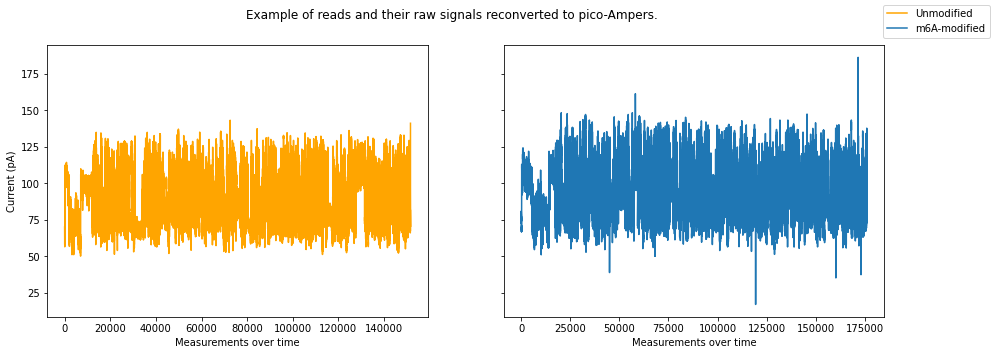

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15,5), sharey=True)
axes[0].plot( raw_to_pA( get_fast5_file(df_unmod_subset.iloc[np.random.randint(0, subset_size_unmod)].path) ), label="Unmodified", c="orange")
axes[1].plot( raw_to_pA( get_fast5_file(df_mod_subset.iloc[np.random.randint(0, subset_size_m6A)].path) ), label="m6A-modified" )
fig.legend()
fig.suptitle("Example of reads and their raw signals reconverted to pico-Ampers.")
axes[0].set_ylabel("Current (pA)")
axes[0].set_xlabel("Measurements over time")
axes[1].set_xlabel("Measurements over time")
plt.show()

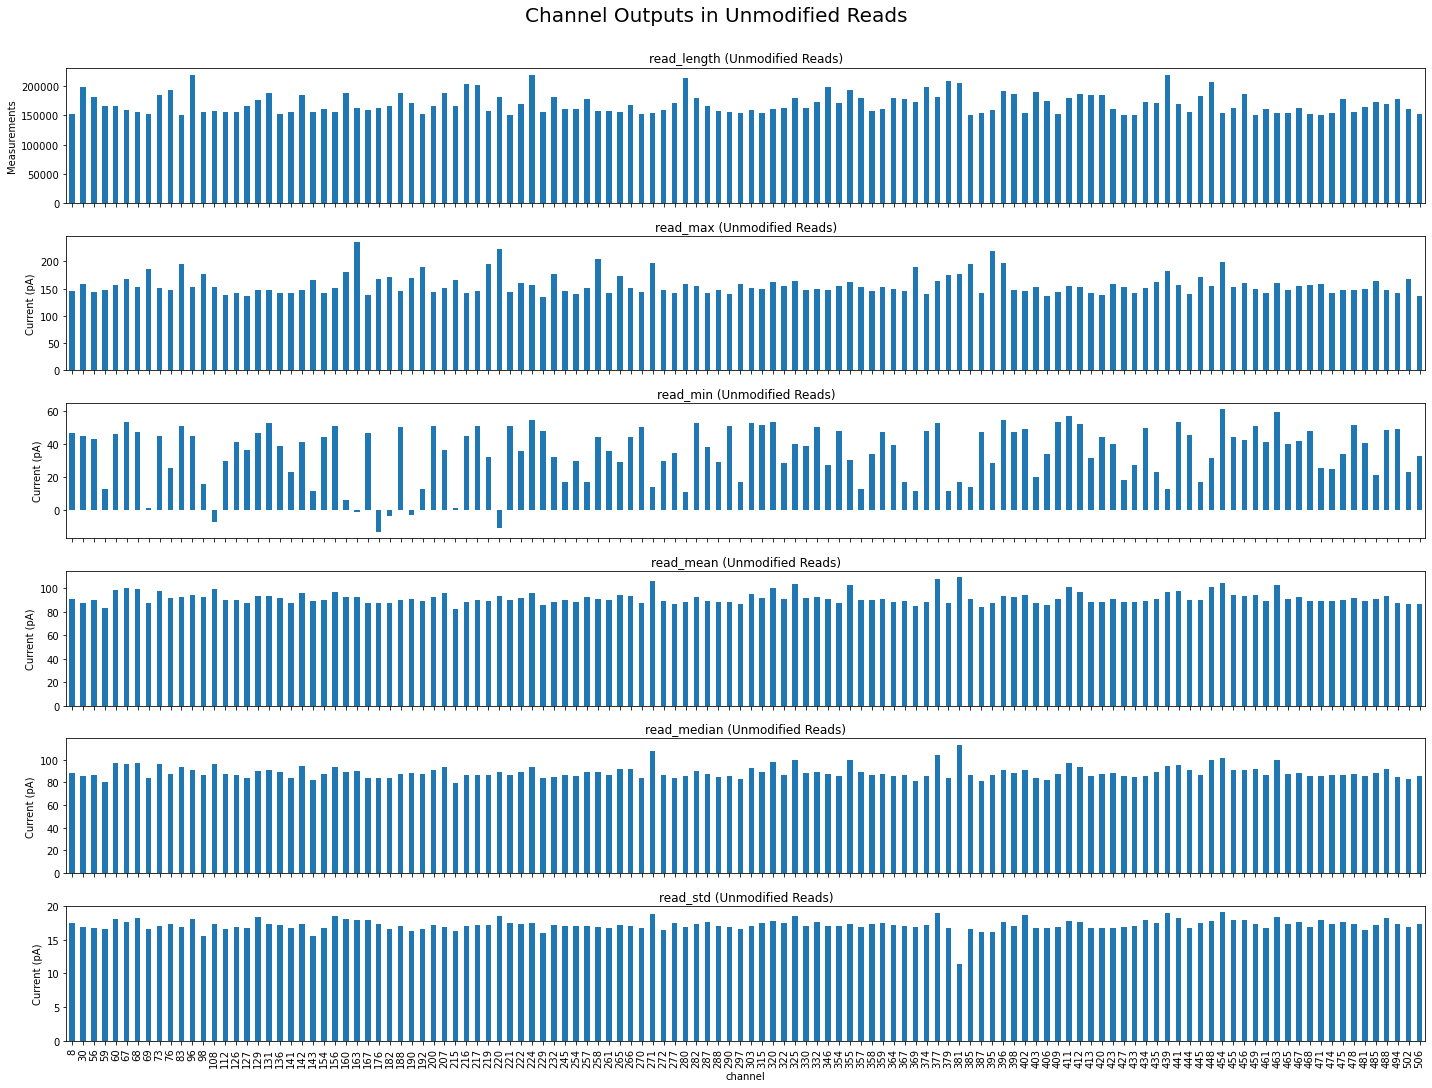

In [9]:
# show variation among channels in unmodified reads
f, axes = plt.subplots(6, 1, figsize=(20,15), sharex=True)
for i, label, ax in zip(["read_length", "read_max", "read_min", "read_mean", "read_median", "read_std"], 
                 ["Measurements", "Current (pA)", "Current (pA)", "Current (pA)", "Current (pA)", "Current (pA)"], 
                 [0,1,2,3,4,5]):
    df_unmod_subset.groupby("channel").mean()[i].plot(kind="bar", ax=axes[ax], title=f"{i} (Unmodified Reads)")
    axes[ax].set_ylabel(label)
plt.suptitle("Channel Outputs in Unmodified Reads", y=1.005, size=20)
plt.tight_layout()
plt.show()

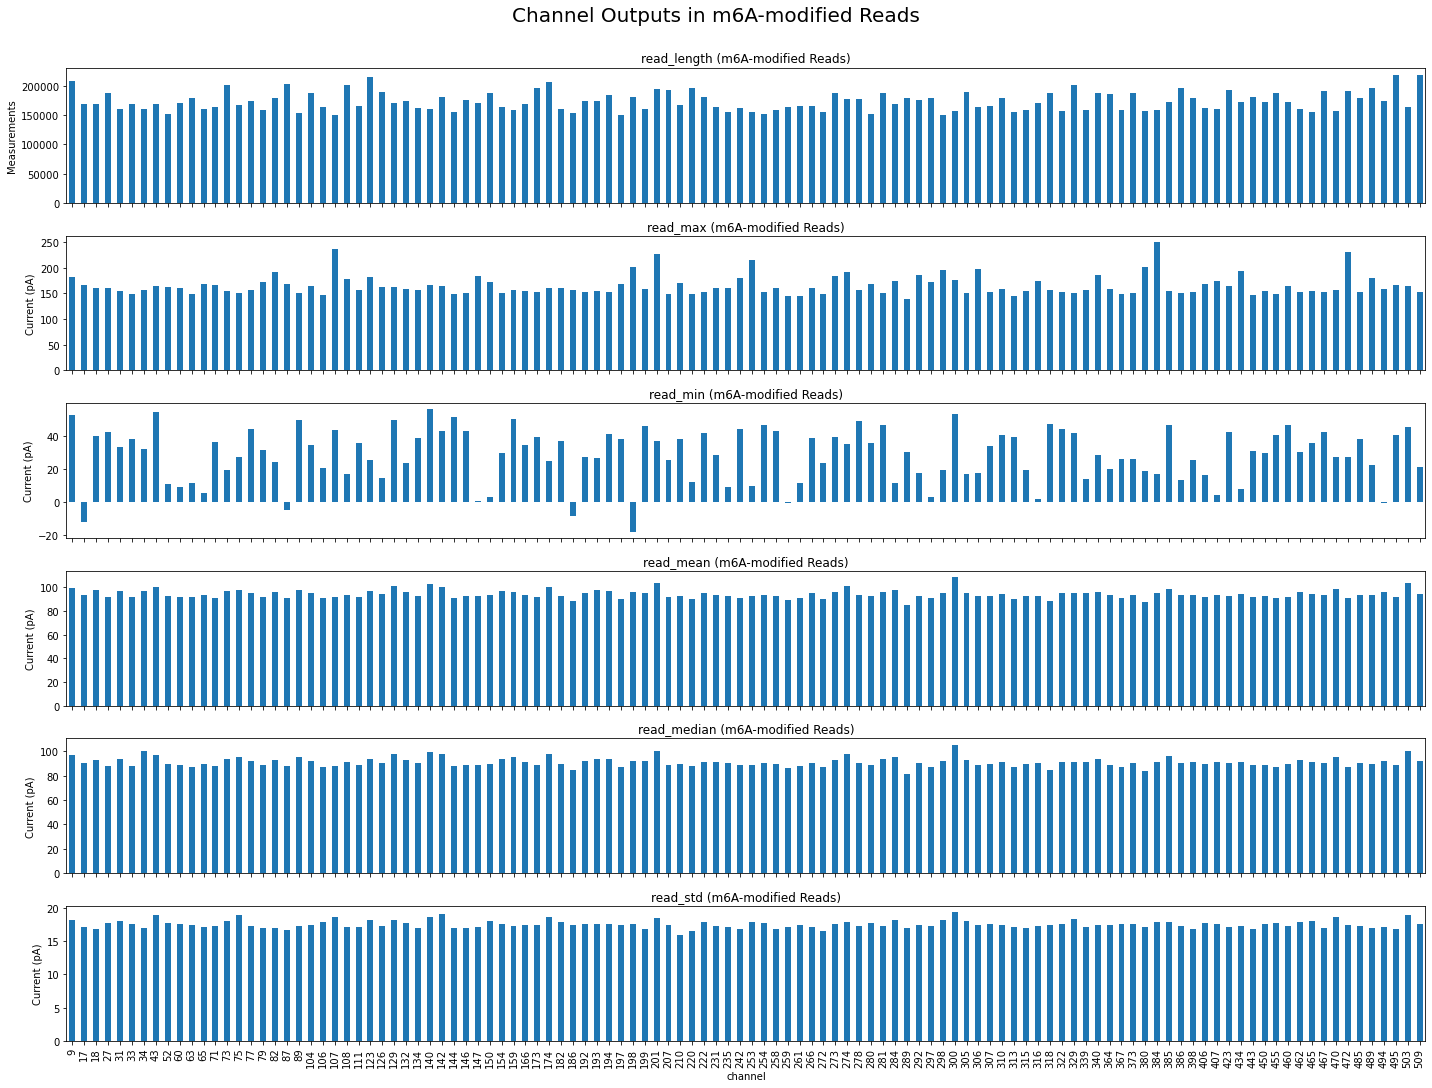

In [10]:
# show variation among channels in modified reads
f, axes = plt.subplots(6, 1, figsize=(20,15), sharex=True)
for i, label, ax in zip(["read_length", "read_max", "read_min", "read_mean", "read_median", "read_std"], 
                 ["Measurements", "Current (pA)", "Current (pA)", "Current (pA)", "Current (pA)", "Current (pA)"], 
                 [0,1,2,3,4,5]):
    df_mod_subset.groupby("channel").mean()[i].plot(kind="bar", ax=axes[ax], title=f"{i} (m6A-modified Reads)")
    axes[ax].set_ylabel(label)
plt.suptitle("Channel Outputs in m6A-modified Reads", y=1.005, size=20)
plt.tight_layout()
plt.show()

## 3.0. Prepare training data

In [11]:
# split unmodified training data into X_train and X_test
X_train, X_test = train_test_split(df_unmod_subset, test_size=0.588)

In [12]:
X_train, X_val = train_test_split(X_train, test_size=0.714)

In [13]:
X_train.shape

(20, 17)

In [14]:
X_val.shape

(50, 17)

In [15]:
X_test.shape

(100, 17)

The next step is to retrieve the reconstructed signals from the disk and to build and to put them into an in-memory pandas DataFrame

In [16]:
X_train_signals = []
for read in X_train.itertuples():
    # signal stored into fast5 are integers and have to be converted to pA 
    # (see the custom function "raw_to_pA" into the "ont_custom_functions.py" file)
    X_train_signals.append( raw_to_pA(get_fast5_file(read.path)) )
X_train_signals = pd.DataFrame(X_train_signals).T
X_train_signals # rows are timepoints of each read and columns are differents files/reads

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,120.409607,77.603439,72.908569,99.835030,79.536621,133.113373,64.209251,136.013145,98.592270,67.109024,65.590096,74.289413,95.554413,82.436394,82.160225,75.256004,100.111198,73.737076,70.423050,141.260353
1,67.247108,76.774933,70.837303,78.846199,75.808342,70.699219,67.799446,62.828407,59.928635,63.794998,62.690323,71.665810,71.389641,81.884056,83.402985,74.841751,74.427498,68.627953,69.456459,75.670258
2,64.623505,77.465355,73.322823,78.846199,75.256004,70.008797,67.937531,62.414154,61.171394,65.175842,63.242661,66.556686,71.251556,78.984283,79.260452,67.523277,71.251556,68.213699,69.318375,75.532173
3,65.175842,78.846199,70.561134,79.260452,75.532173,71.527725,67.937531,60.480972,58.547791,65.313927,63.380745,69.456459,68.766037,77.327271,79.398537,68.627953,67.937531,67.661362,67.385193,75.256004
4,65.452011,76.222595,72.770485,76.774933,73.875160,71.527725,67.247108,59.928635,61.033310,68.351784,62.552238,67.523277,65.452011,71.941978,83.679153,69.594543,62.690323,67.661362,68.351784,73.460907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217175,NaN,NaN,NaN,NaN,93.897400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
217176,NaN,NaN,NaN,NaN,100.525452,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
217177,NaN,NaN,NaN,NaN,94.173569,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
217178,NaN,NaN,NaN,NaN,91.273796,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
print("Memory used by DataFrame is about {} mb".format(round( X_train_signals.memory_usage().sum() / 1048576, 2 )) )

Memory used by DataFrame is about 33.14 mb


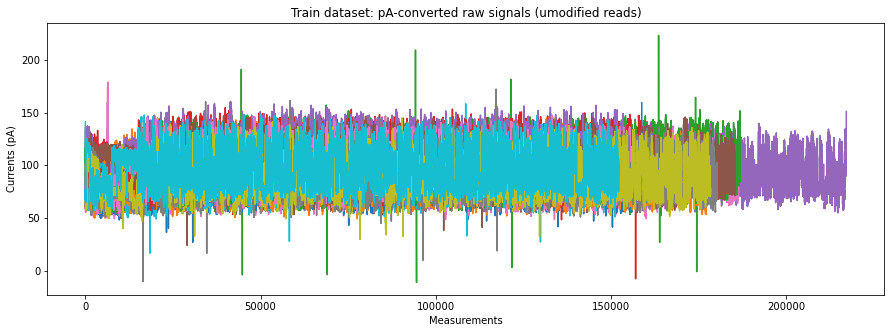

In [18]:
X_train_signals.plot(figsize=(15,5), legend=None)
plt.title("Train dataset: pA-converted raw signals (umodified reads)")
plt.ylabel("Currents (pA)")
plt.xlabel("Measurements")
plt.show()

## 3.1. Create sequences

In [19]:
# defining model training parameters
TIME_STEPS = 288
n_features = 1
epochs = 100
batch_size = 128

In [20]:
def create_sequences(values, time_steps=TIME_STEPS):
    '''
    Function to create a time_step version of the sequence.
    '''
    output=[]
    for i in range(len(values)+1 - time_steps):
        output.append(values[i:(i+time_steps)])
    return np.stack(output).reshape(len(output), time_steps, 1)

def recostruct_sequence(timestep_sequence):
    '''
    Function to reconstruct the sequence starting
    from the time_step version.
    '''
    output = []
    output += list(timestep_sequence[0].ravel())
    for i in timestep_sequence[1:]:
        output.append( i.ravel()[-1] )
    #output += list(timestep_sequence[-1].ravel())
    output = np.array(output)
    return output


def get_mae(signal, model):
    '''
    Function to get the reconstruction MAE error from a raw signal after the transformation in time_steps
    version and prediction of the reconstructed signal.
    '''
    X_scaled = StandardScaler().fit_transform(signal.dropna().values.reshape(-1,1))
    time_steps = create_sequences(X_scaled)
    time_step_pred = model.predict(time_steps)
    mae_loss = np.mean(np.abs(time_step_pred - time_steps.reshape(time_steps.shape[0], time_steps.shape[1], 1)), axis=1)
    return mae_loss

## 4.0. Autoencoder's Neural Network Model

In [21]:
model = Sequential(
    [
        Input(shape=(288, 1)),
        Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        Dropout(rate=0.3),
        Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        Dropout(rate=0.3),
        Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 144, 32)           256       
_________________________________________________________________
dropout (Dropout)            (None, 144, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 72, 16)            3600      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 144, 16)           1808      
_________________________________________________________________
dropout_1 (Dropout)          (None, 144, 16)           0         
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 288, 32)           3616      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 288, 1)            2

In [22]:
# Prepare a directory to store all the checkpoints and history
checkpoint_dir = os.path.join("ckpt","ckpt" + version + date)
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
    
# define the checkpoint
filepath = os.path.join(checkpoint_dir, "model"+version+date+".h5")
filepath_history = os.path.join(checkpoint_dir, "model"+version+date+"_history.pickle")
filepath_X_train_sample_used = os.path.join(checkpoint_dir, "model"+version+date+"_Xtrain_used.pickle")
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='loss', patience=5)
callbacks_list = [checkpoint, early_stopping]

print(date)
print(version)

2021_03_10_12_55_46
_v3_0_CNN_curckake_qual_filt_HIGH_NUM_IMPROVED


In [23]:
# define custom function for the training: 
#      1) data generator for the model's training and 
#      2) batches total number calculator 

def dataGenerator(X_train_signals, batch_size):
    '''
    Function produce a generator of batches for the model.fit() method.
    '''
    while True: #generators for keras must be infinite
        for i in X_train_signals.columns:
            X_scaled = StandardScaler().fit_transform(X_train_signals[i].dropna().values.reshape(-1,1)) 
            X_train_time_steps = create_sequences(X_scaled)

            totalSamps = X_train_time_steps.shape[0]
            batches = totalSamps // batch_size

            if totalSamps % batch_size > 0:
                batches+=1

            for batch in range(batches):
                section = slice(batch*batch_size,(batch+1)*batch_size)
                yield (X_train_time_steps[section], X_train_time_steps[section])


def cal_expectedTotalNumberOfYieldsForOneEpoch(X_train_signals, batch_size):
    '''
    Function to calculate total number of generator yealds (batch steps)
    to be considered as one whole epoch by the model.fit() method.
    '''
    expectedTotalNumberOfYieldsForOneEpoch = []
    with tqdm(total=len(X_train_signals.columns)) as pbar:
        for a in X_train_signals.columns:
            X_scaled = StandardScaler().fit_transform(X_train_signals[a].dropna().values.reshape(-1,1))
            X_train_time_steps = create_sequences(X_scaled)
            totalSamps = X_train_time_steps.shape[0]
            batches = totalSamps // batch_size
            if totalSamps % batch_size > 0:
                batches+=1
            expectedTotalNumberOfYieldsForOneEpoch.append(batches)
            pbar.update(1)
    expectedTotalNumberOfYieldsForOneEpoch = np.sum(expectedTotalNumberOfYieldsForOneEpoch)
    return expectedTotalNumberOfYieldsForOneEpoch

In [24]:
# TRAINING OF THE MODEL on unmodified reads

start_time = datetime.now()
# calculate total batches per epoch
print("Calculating total number of batches per epoch...")
expectedTotalNumberOfYieldsForOneEpoch = cal_expectedTotalNumberOfYieldsForOneEpoch(X_train_signals, batch_size)

# istantiate generator
gen = dataGenerator(X_train_signals, batch_size)

# fit the model with callbacks.
print("Training of the model started:")
history = model.fit(gen,
                    steps_per_epoch = expectedTotalNumberOfYieldsForOneEpoch,
                    epochs = epochs,
                    callbacks=callbacks_list)
end_time = datetime.now()
print("End of Training...")
print(f"Elapsed time: {end_time - start_time}")

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Calculating total number of batches per epoch...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.43it/s]


Training of the model started:
Epoch 1/100
26243/26243 [==============================] - 1270s 48ms/step - loss: 0.0553

Epoch 00001: loss improved from inf to 0.02560, saving model to ckpt\ckpt_v3_0_CNN_curckake_qual_filt_HIGH_NUM_IMPROVED2021_03_10_12_55_46\model_v3_0_CNN_curckake_qual_filt_HIGH_NUM_IMPROVED2021_03_10_12_55_46.h5
Epoch 2/100
26243/26243 [==============================] - 1201s 46ms/step - loss: 0.0112

Epoch 00002: loss improved from 0.02560 to 0.01087, saving model to ckpt\ckpt_v3_0_CNN_curckake_qual_filt_HIGH_NUM_IMPROVED2021_03_10_12_55_46\model_v3_0_CNN_curckake_qual_filt_HIGH_NUM_IMPROVED2021_03_10_12_55_46.h5
Epoch 3/100
26243/26243 [==============================] - 1206s 46ms/step - loss: 0.0092

Epoch 00003: loss improved from 0.01087 to 0.00930, saving model to ckpt\ckpt_v3_0_CNN_curckake_qual_filt_HIGH_NUM_IMPROVED2021_03_10_12_55_46\model_v3_0_CNN_curckake_qual_filt_HIGH_NUM_IMPROVED2021_03_10_12_55_46.h5
Epoch 4/100
26243/26243 [========================

26243/26243 [==============================] - 1225s 47ms/step - loss: 0.0054

Epoch 00031: loss did not improve from 0.00536
Epoch 32/100
26243/26243 [==============================] - 1132s 43ms/step - loss: 0.0054

Epoch 00032: loss improved from 0.00536 to 0.00531, saving model to ckpt\ckpt_v3_0_CNN_curckake_qual_filt_HIGH_NUM_IMPROVED2021_03_10_12_55_46\model_v3_0_CNN_curckake_qual_filt_HIGH_NUM_IMPROVED2021_03_10_12_55_46.h5
Epoch 33/100
26243/26243 [==============================] - 1137s 43ms/step - loss: 0.0053

Epoch 00033: loss improved from 0.00531 to 0.00530, saving model to ckpt\ckpt_v3_0_CNN_curckake_qual_filt_HIGH_NUM_IMPROVED2021_03_10_12_55_46\model_v3_0_CNN_curckake_qual_filt_HIGH_NUM_IMPROVED2021_03_10_12_55_46.h5
Epoch 34/100
26243/26243 [==============================] - 1268s 48ms/step - loss: 0.0047

Epoch 00034: loss improved from 0.00530 to 0.00488, saving model to ckpt\ckpt_v3_0_CNN_curckake_qual_filt_HIGH_NUM_IMPROVED2021_03_10_12_55_46\model_v3_0_CNN_curcka

In [25]:
# load last best model
model = keras.models.load_model(filepath)

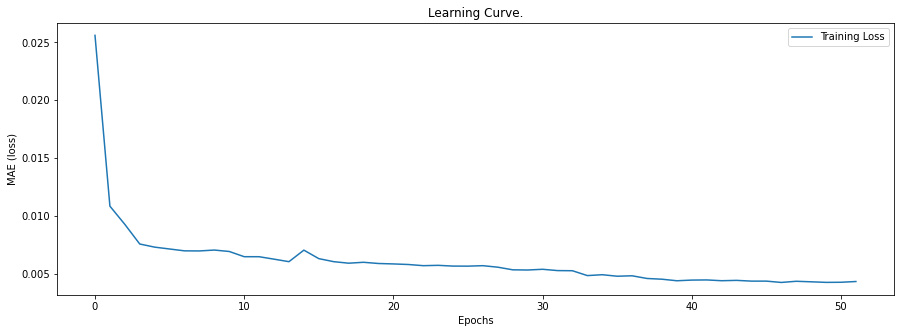

In [26]:
# plot the training and validation losses of all trainings in this session.
plt.figure(figsize=(15,5))
plt.plot(history.history["loss"], label="Training Loss")
plt.title("Learning Curve.")
plt.xlabel("Epochs")
plt.ylabel("MAE (loss)")
plt.legend()
plt.show()

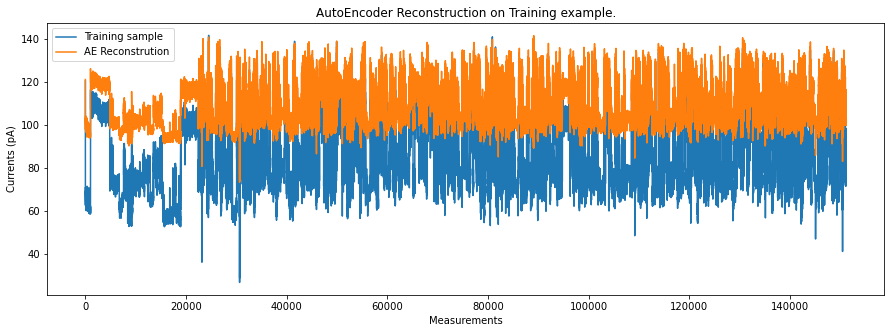

In [27]:
# Visualize reconstructed signal of on a training sample 
sc = StandardScaler()
train_sample = X_train_signals[0].dropna().values.reshape(-1,1)
train_sample_sc = sc.fit_transform(train_sample)
train_sample_time_step = create_sequences(train_sample_sc)
train_sample_pred = model.predict(create_sequences(train_sample_sc))
reconstructed_signal = recostruct_sequence(train_sample_pred)
reconstructed_signal = sc.inverse_transform(reconstructed_signal)

# plot results
plt.figure(figsize=(15,5))
plt.plot(train_sample, label="Training sample")
plt.plot(reconstructed_signal, label="AE Reconstrution")
plt.title("AutoEncoder Reconstruction on Training example.")
plt.xlabel("Measurements")
plt.ylabel("Currents (pA)")
plt.legend()
plt.show()

In [28]:
# Getting all the threshold computed for the training samples by the model
thresholds = []
mae_losses = []
with tqdm(total=len(X_train_signals.columns)) as pbar:
    for i in X_train_signals.columns:
        train_mae_loss = get_mae(X_train_signals[i], model)
        mae_losses.append(train_mae_loss)

        # Get reconstruction loss thresholds.
        threshold = np.max(train_mae_loss)
        thresholds.append(threshold)
        pbar.update(1)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [08:06<00:00, 24.30s/it]


In [29]:
threshold_max = round(np.max(thresholds), 2)
print("Mean Threshold +/- S.D. on Training samples:", round(np.mean(thresholds), 2), "+/-", round(np.std(thresholds), 2), "S.D.")
print("Max Value for Threshold in training samples:", threshold_max)

Mean Threshold +/- S.D. on Training samples: 2.34 +/- 0.06 S.D.
Max Value for Threshold in training samples: 2.47


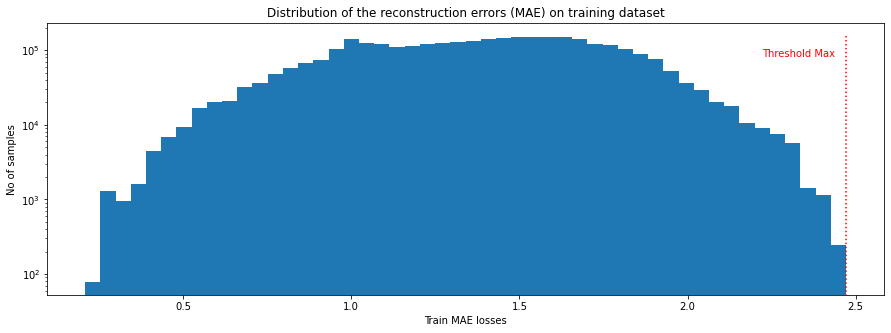

Reconstruction error threshold:  2.47


In [30]:
# plotting MAE reconstruction errors of the training dataset to visualize the maximum threshold.
plt.figure(figsize=(15,5))
plt.hist(np.concatenate(mae_losses), bins=50)
plt.title("Distribution of the reconstruction errors (MAE) on training dataset")
plt.vlines(threshold_max, plt.axis()[2], plt.axis()[3], colors="r", linestyles="dotted")
plt.yscale(value="log")
plt.xlabel("Train MAE losses")
plt.ylabel("No of samples")
plt.text(threshold_max*0.9, plt.axis()[3]*0.35, "Threshold Max", c="r")
plt.show()

print("Reconstruction error threshold: ", threshold_max)

## 4.1. Evaluation of the model on X_val dataset.

In [31]:
X_val_signals = []
for read in X_val.itertuples():
    # signal stored into fast5 are integers and have to be converted to pA 
    # (see the custom function "raw_to_pA" into the "ont_custom_functions.py" file)
    X_val_signals.append( raw_to_pA(get_fast5_file(read.path)) )
X_val_signals = pd.DataFrame(X_val_signals).T
X_val_signals # rows are timepoints of each read and columns are differents files/reads

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,67.937531,58.823959,68.904121,65.590096,69.042206,87.683601,69.042206,120.409607,95.968666,77.465355,...,102.182465,74.841751,76.498764,70.423050,53.714836,74.979836,70.008797,74.841751,105.082237,71.113472
1,67.523277,59.652466,66.970940,64.623505,65.175842,89.478699,72.908569,67.247108,58.685875,66.970940,...,104.529900,74.289413,76.913017,72.632401,53.024414,68.766037,67.247108,74.289413,71.527725,72.908569
2,68.351784,58.823959,69.732628,68.351784,66.556686,89.340614,74.151329,64.623505,58.685875,69.318375,...,109.224770,74.013245,77.051102,72.356232,53.024414,67.385193,67.661362,74.013245,68.213699,70.423050
3,69.456459,59.928635,68.351784,64.761589,65.866264,88.235939,74.841751,65.175842,58.962044,67.799446,...,107.153503,74.979836,77.189186,68.627953,53.852921,69.732628,69.594543,74.979836,73.875160,68.213699
4,66.418602,59.376297,68.904121,61.309479,65.866264,87.545517,73.598991,65.452011,59.514381,66.418602,...,104.529900,73.184738,76.084511,70.008797,55.786102,71.251556,70.008797,73.184738,70.008797,64.347336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219651,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
219652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
219653,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
219654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
print("Memory used by DataFrame is about {} mb".format(round( X_val_signals.memory_usage().sum() / 1048576, 2 )) )

Memory used by DataFrame is about 83.79 mb


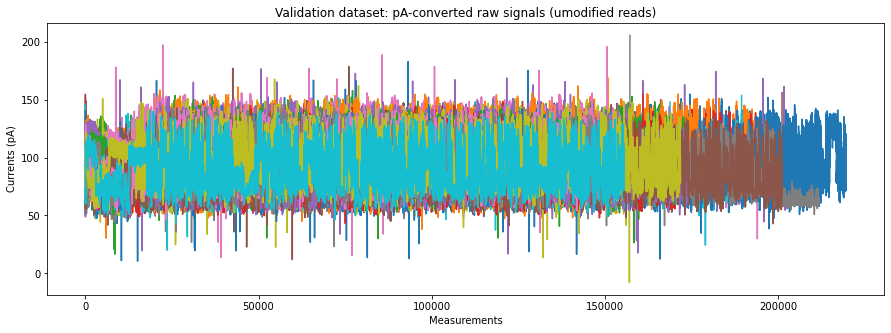

In [33]:
X_val_signals.plot(figsize=(15,5), legend=None)
plt.title("Validation dataset: pA-converted raw signals (umodified reads)")
plt.ylabel("Currents (pA)")
plt.xlabel("Measurements")
plt.show()

In [34]:
# Getting all the MAE reconstruction errors computed for the validation samples by the model
val_mae_losses = [] # where are stored the mae losses of validation samples.
val_sum_anomalies = [] # where are stored the cumulative number of anomalies per sample.
val_anomaly_indices = [] # where are stored the indices of the anomalies with respect the time_step version of the samples
with tqdm(total=len(X_val_signals.columns)) as pbar:
    for i in X_val_signals.columns:
        val_mae_loss = get_mae(X_val_signals[i], model)
        val_mae_losses.append(val_mae_loss)
        anomalies = val_mae_loss > threshold_max
        sum_anomalies = np.sum(anomalies)
        anomalies_indices = np.where(anomalies)
        val_sum_anomalies.append(sum_anomalies)
        val_anomaly_indices.append(anomalies_indices)

        pbar.update(1)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [24:09<00:00, 28.99s/it]


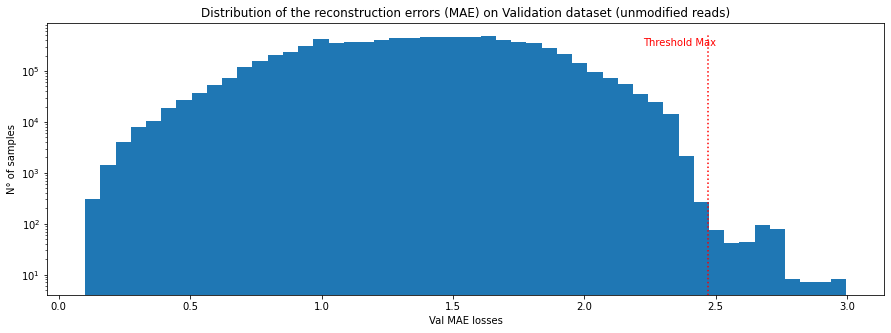

Number of anomaly samples in validation reads: 385


In [35]:
# plotting MAE reconstruction errors of the validation dataset.
plt.figure(figsize=(15,5))
plt.hist(np.concatenate(val_mae_losses), bins=50)
plt.title("Distribution of the reconstruction errors (MAE) on Validation dataset (unmodified reads)")
plt.vlines(threshold_max, plt.axis()[2], plt.axis()[3], colors="r", linestyles="dotted")
plt.yscale(value="log")
plt.xlabel("Val MAE losses")
plt.ylabel("N° of samples")
plt.text(threshold_max*0.9, plt.axis()[3]*0.35, "Threshold Max", c="r")
plt.show()

print("Number of anomaly samples in validation reads:", np.sum(val_sum_anomalies))

## 4.2. Evaluation of the model on m6A modified dataset

In [36]:
m6A_train, m6A_test = train_test_split(df_mod_subset, test_size=0.666)
print("m6A_train dataset shape (measurements, reads):", m6A_train.shape)
print("m6A_test dataset shape (measurements, reads):", m6A_test.shape)

m6A_train dataset shape (measurements, reads): (50, 17)
m6A_test dataset shape (measurements, reads): (100, 17)


In [37]:
m6A_train_signals = []
for read in m6A_train.itertuples():
    # signal stored into fast5 are integers and have to be converted to pA 
    # (see the custom function "raw_to_pA" into the "ont_custom_functions.py" file)
    m6A_train_signals.append( raw_to_pA(get_fast5_file(read.path)) )
m6A_train_signals = pd.DataFrame(m6A_train_signals).T
m6A_train_signals # rows are timepoints of each read and columns are differents files/reads

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,87.630208,112.395266,80.742884,84.552893,103.309860,77.958646,74.441715,143.168416,128.367997,91.000600,...,82.647888,82.940966,77.372491,78.544802,84.699432,112.981422,28.868145,87.337130,76.639797,82.794427
1,72.390172,74.588254,78.691340,78.984418,74.588254,76.639797,79.570573,73.562482,81.035961,88.802518,...,81.768655,84.552893,79.570573,74.588254,79.277496,77.079414,26.376986,90.707523,71.804016,81.182500
2,73.122866,73.855560,75.760564,76.786336,72.097094,75.614025,77.958646,74.002099,83.087505,87.776747,...,82.647888,79.424034,77.665569,72.536710,72.976327,77.079414,28.281990,92.319450,74.295176,74.881331
3,71.364400,72.829788,73.855560,77.079414,68.726701,74.295176,75.174409,74.148637,81.768655,87.923285,...,80.449806,78.105185,79.277496,74.441715,70.045551,77.519030,25.937369,90.560984,71.657478,75.907103
4,70.631706,69.166318,77.079414,78.398263,65.209770,76.493258,72.097094,71.657478,81.768655,88.069824,...,82.501349,77.079414,79.130957,77.225952,69.019779,75.174409,27.695835,91.586756,72.976327,75.174409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211805,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
211806,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
211807,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
211808,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
print("Memory used by DataFrame is about {} mb".format(round( m6A_train_signals.memory_usage().sum() / 1048576, 2 )) )

Memory used by DataFrame is about 80.8 mb


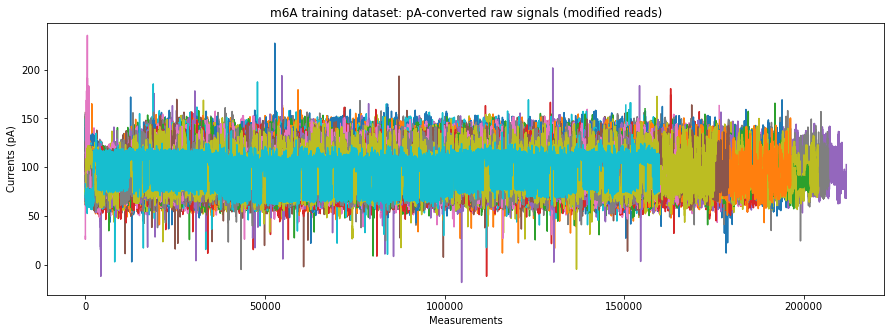

In [39]:
m6A_train_signals.plot(figsize=(15,5), legend=None)
plt.title("m6A training dataset: pA-converted raw signals (modified reads)")
plt.ylabel("Currents (pA)")
plt.xlabel("Measurements")
plt.show()

In [40]:
# Getting all the MAE reconstruction errors computed for the m6A training samples by the model
m6A_train_mae_losses = [] # where are stored the mae losses of m6A training samples.
m6A_train_sum_anomalies = [] # where are stored the cumulative number of anomalies per sample.
m6A_train_anomaly_indices = [] # where are stored the indices of the anomalies with respect the time_step version of the samples
with tqdm(total=len(m6A_train_signals.columns)) as pbar:
    for i in m6A_train_signals.columns:
        m6A_train_mae_loss = get_mae(m6A_train_signals[i], model)
        m6A_train_mae_losses.append(m6A_train_mae_loss)
        anomalies = m6A_train_mae_loss > threshold_max
        sum_anomalies = np.sum(anomalies)
        anomalies_indices = np.where(anomalies)
        m6A_train_sum_anomalies.append(sum_anomalies)
        m6A_train_anomaly_indices.append(anomalies_indices)

        pbar.update(1)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [26:43<00:00, 32.06s/it]


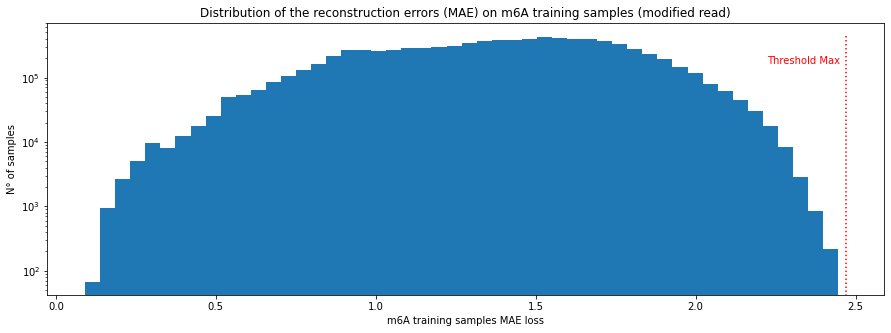

Number of anomaly samples: 0


In [41]:
plt.figure(figsize=(15,5))
plt.hist(np.concatenate(m6A_train_mae_losses), bins=50)
plt.title("Distribution of the reconstruction errors (MAE) on m6A training samples (modified read)")
plt.vlines(threshold_max, plt.axis()[2], plt.axis()[3], colors="r", linestyles="dotted")
plt.text(threshold_max*0.9, plt.axis()[3]*0.35, "Threshold Max", c="r")
plt.yscale(value="log")
plt.xlabel("m6A training samples MAE loss")
plt.ylabel("N° of samples")
plt.show()

anomalies_m6A_train = np.concatenate(m6A_train_mae_losses) > threshold_max
print("Number of anomaly samples:", np.sum(anomalies_m6A_train))

## 4.3. Best Threshold choise.

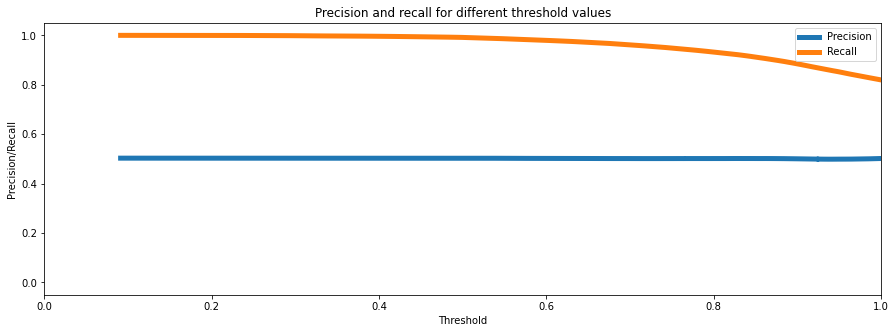

In [42]:
y_m6A_train = np.array([1 for i in np.concatenate(m6A_train_mae_losses)]) # real class vector for m6A_train
y_unmod_val = np.array([0 for i in np.concatenate(val_mae_losses)]) # real class vector for X_val unmodifed reads
# concatenate both of them into single vector
mae_total_val = np.concatenate([np.concatenate(m6A_train_mae_losses), np.concatenate(val_mae_losses)]) 
# concatenate also class labels into a single vector
y_total_val = np.concatenate([y_m6A_train, y_unmod_val]) 

# calculating precision/reacall scores over the threshold values
precision_rt, recall_rt, threshold_rt = precision_recall_curve(y_total_val, mae_total_val)

# producing precision/recall vs threshold curves
plt.figure(figsize=(15,5))
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.xlim(0, 1)
plt.legend()
plt.show()

Obviously, since the classes have been assigned in a not-common manner, with m6A modified reads containing also normal events and bases, the Precision/Recall vs threshold curves are not easily interpretable. Anyway they give some information about the behaviour of the model. It's better to use these information together with another way to see the problem that is the number of anomalies found in unmodified and m6A-modified reads by the variation of the threshold value on the validations sets as following:

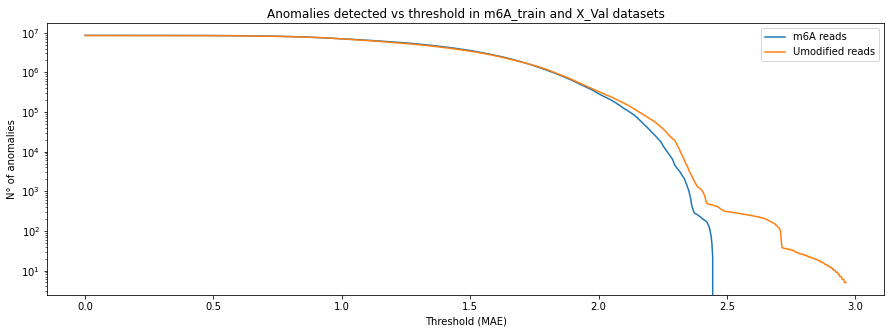

In [43]:
# evaluate how the number of detected anomalies changes in both 
# m6A_train and unmodified X_val samples in function of the threshold value.
trs = []
m6A_over_t = []
unmod_over_t =[]
for t in np.linspace(0, threshold_max*1.20, 1000):
    trs.append(t)
    m6A_over_t.append(np.sum(np.concatenate(m6A_train_mae_losses) > t))
    unmod_over_t.append(np.sum(np.concatenate(val_mae_losses) > t))

plt.figure(figsize=(15,5))
plt.plot(trs, m6A_over_t, label="m6A reads")
plt.plot(trs, unmod_over_t, label="Umodified reads")
plt.xlabel("Threshold (MAE)")
plt.ylabel("N° of anomalies")
plt.yscale("log")
plt.title("Anomalies detected vs threshold in m6A_train and X_Val datasets")
plt.legend()
plt.show()

In [44]:
# Detecting a good threshold as the minimum threshold value with 0 anomalies in unmodified reads
min_value_umod_anom = np.min(np.array(unmod_over_t))
min_index_unmod = np.min(np.argwhere(np.array(unmod_over_t) == min_value_umod_anom)) # first index where no anomalies are detected in unmodified data
new_threshold = trs[min_index_unmod] # threshold with 0 anomalies in unmodified reads
print("Best Threshold is:", new_threshold)

Best Threshold is: 2.958066066066066


A good threshold seems to be: 2.958066066066066 MAE

Number of anomalies in m6A_train samples: 0
Percentage of anomalies in modified m6A_train dataset on total measurements evaluated: 0.0 %

Number of anomalies in X_val samples: 5
Percentage of anomalies in unmodified X_val dataset on total measurements evaluated: 6e-05 %

m6A_train/X_val anomalies ratio 0.0


C:\Users\adria\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


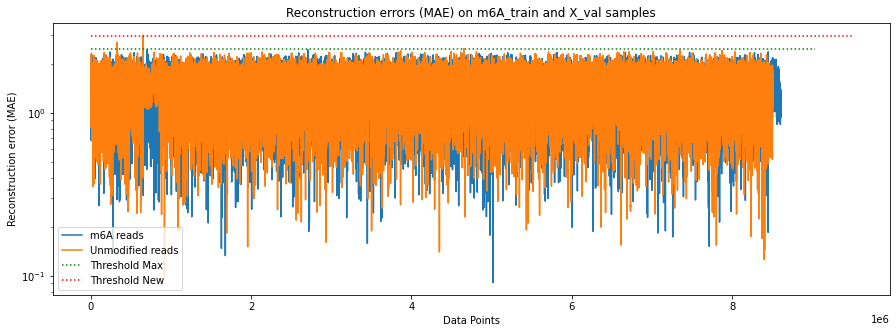

In [45]:
# Results on m6A_train and X_val datasets:
print(f"A good threshold seems to be: {new_threshold} MAE\n")
# Results on m6A_train and X_val datasets:
print("Number of anomalies in m6A_train samples:", np.sum(np.concatenate(m6A_train_mae_losses) > new_threshold))
print("Percentage of anomalies in modified m6A_train dataset on total measurements evaluated:", round(np.sum(np.concatenate(m6A_train_mae_losses) > new_threshold) / np.concatenate(m6A_train_mae_losses).shape[0] * 100, 5), "%\n" )
print("Number of anomalies in X_val samples:", np.sum(np.concatenate(val_mae_losses) > new_threshold))
print("Percentage of anomalies in unmodified X_val dataset on total measurements evaluated:", round(np.sum(np.concatenate(val_mae_losses) > new_threshold) / np.concatenate(val_mae_losses).shape[0] * 100, 5), "%\n" )
print("m6A_train/X_val anomalies ratio", 
        np.sum(np.concatenate(m6A_train_mae_losses) > new_threshold) / 
        np.sum(np.concatenate(val_mae_losses) > new_threshold))

# Compare the Reconstruction MAE of the model in both the datasets with respect the max_threshold value
# computed in the training dataset.
plt.figure(figsize=(15,5))
plt.title("Reconstruction errors (MAE) on m6A_train and X_val samples")
plt.plot(np.concatenate(m6A_train_mae_losses), label="m6A reads", zorder=0)
plt.plot(np.concatenate(val_mae_losses), label="Unmodified reads", zorder=1)
plt.yscale(value="log")
plt.xlabel("Data Points")
plt.ylabel("Reconstruction error (MAE)")
plt.hlines(threshold_max, -1, plt.axis()[1], colors="g", linestyles="dotted", label="Threshold Max", zorder=3)
plt.hlines(new_threshold, -1, plt.axis()[1], colors="r", linestyles="dotted", label="Threshold New", zorder=4)
plt.legend()
plt.show()

## 5.0. Evaluation on test sets

In [46]:
X_test_signals = []
for read in X_test.itertuples():
    # signal stored into fast5 are integers and have to be converted to pA 
    # (see the custom function "raw_to_pA" into the "ont_custom_functions.py" file)
    X_test_signals.append( raw_to_pA(get_fast5_file(read.path)) )
X_test_signals = pd.DataFrame(X_test_signals).T
X_test_signals # rows are timepoints of each read and columns are differents files/reads

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,61.585648,93.759315,71.665810,112.538795,138.912918,112.676880,77.051102,97.349510,67.937531,72.080063,...,98.730354,73.737076,68.489868,122.480873,118.200256,69.732628,66.694771,127.451912,65.728180,73.046654
1,59.928635,65.452011,69.318375,67.385193,73.737076,63.933083,69.042206,73.598991,70.146881,69.594543,...,82.436394,74.703667,68.627953,69.870712,78.017693,73.322823,69.870712,73.322823,64.623505,70.975388
2,62.690323,65.175842,69.042206,67.937531,74.565582,65.313927,70.284966,72.770485,70.837303,70.561134,...,81.884056,75.394089,67.799446,71.113472,80.365128,73.875160,69.594543,71.803894,61.033310,68.766037
3,63.242661,66.142433,67.247108,68.489868,71.941978,64.623505,69.732628,72.080063,70.837303,69.456459,...,89.478699,73.046654,68.075615,68.627953,80.641296,70.837303,69.180290,70.146881,60.480972,70.975388
4,59.100128,61.033310,70.146881,70.284966,67.109024,67.247108,70.008797,73.598991,69.042206,68.766037,...,83.679153,75.946426,68.213699,69.042206,76.913017,72.080063,70.284966,70.146881,60.204803,70.699219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90.859543,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
219041,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.955322,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
219042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.178017,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
219043,NaN,NaN,NaN,NaN,NaN,NaN,NaN,122.895126,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
print("Memory used by DataFrame is about {} mb".format(round( X_test_signals.memory_usage().sum() / 1048576, 2 )) )

Memory used by DataFrame is about 167.12 mb


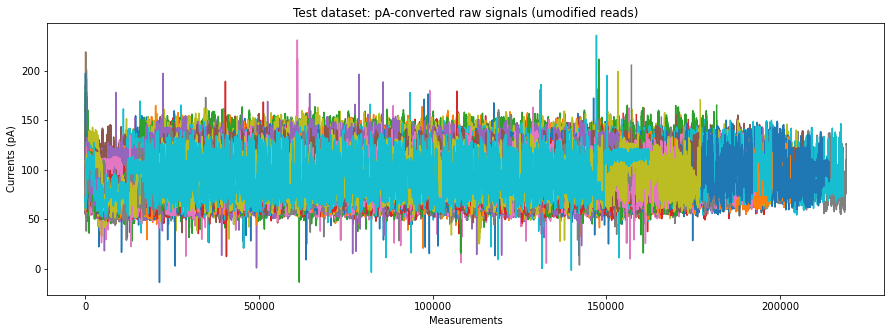

In [48]:
X_test_signals.plot(figsize=(15,5), legend=None)
plt.title("Test dataset: pA-converted raw signals (umodified reads)")
plt.ylabel("Currents (pA)")
plt.xlabel("Measurements")
plt.show()

In [49]:
# Getting all the MAE reconstruction errors computed for the test samples by the model
test_mae_losses = [] # where are stored the mae losses of test samples.
test_sum_anomalies = [] # where are stored the cumulative number of anomalies per sample.
test_anomaly_indices = [] # where are stored the indices of the anomalies with respect the time_step version of the samples
with tqdm(total=len(X_test_signals.columns)) as pbar:
    for i in X_test_signals.columns:
        test_mae_loss = get_mae(X_test_signals[i], model)
        test_mae_losses.append(test_mae_loss)
        anomalies = test_mae_loss > new_threshold
        sum_anomalies = np.sum(anomalies)
        anomalies_indices = np.where(anomalies)
        test_sum_anomalies.append(sum_anomalies)
        test_anomaly_indices.append(anomalies_indices)

        pbar.update(1)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [47:21<00:00, 28.42s/it]


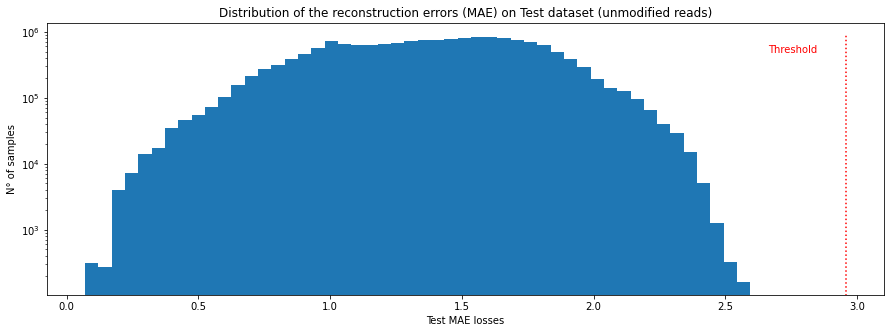

Number of anomaly samples in test reads: 0


In [50]:
# plotting MAE reconstruction errors of the test dataset.
plt.figure(figsize=(15,5))
plt.hist(np.concatenate(test_mae_losses), bins=50)
plt.title("Distribution of the reconstruction errors (MAE) on Test dataset (unmodified reads)")
plt.vlines(new_threshold, plt.axis()[2], plt.axis()[3], colors="r", linestyles="dotted")
plt.yscale(value="log")
plt.xlabel("Test MAE losses")
plt.ylabel("N° of samples")
plt.text(new_threshold*0.9, plt.axis()[3]*0.35, "Threshold", c="r")
plt.show()
print("Number of anomaly samples in test reads:", np.sum(test_sum_anomalies))

In [51]:
m6A_test_signals = []
for read in m6A_test.itertuples():
    # signal stored into fast5 are integers and have to be converted to pA 
    # (see the custom function "raw_to_pA" into the "ont_custom_functions.py" file)
    m6A_test_signals.append( raw_to_pA(get_fast5_file(read.path)) )
m6A_test_signals = pd.DataFrame(m6A_test_signals).T
m6A_test_signals # rows are timepoints of each read and columns are differents files/reads

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,80.010190,130.126462,166.761165,80.889423,91.879833,85.432126,76.493258,101.844472,140.530718,81.622117,...,75.614025,70.778245,76.053642,175.993110,86.164820,82.208272,67.847469,107.559486,90.121367,71.364400
1,80.889423,77.225952,87.337130,80.596345,83.673660,87.044053,72.536710,75.174409,84.406354,76.346719,...,74.734793,69.166318,70.778245,90.854062,71.657478,73.855560,66.821697,80.010190,77.225952,72.536710
2,81.475578,79.570573,87.190591,77.812108,80.303267,84.406354,77.079414,73.122866,79.863651,78.105185,...,78.984418,68.433624,72.829788,89.681751,73.415943,72.390172,75.907103,74.148637,75.760564,72.390172
3,81.768655,72.829788,87.190591,77.812108,78.691340,89.242135,76.053642,77.519030,78.984418,74.588254,...,79.863651,68.580163,74.441715,89.388673,67.261313,70.778245,76.346719,72.976327,79.717112,72.097094
4,80.303267,78.105185,81.182500,75.320948,80.010190,80.889423,74.881331,76.200181,77.372491,71.217861,...,78.398263,65.942464,70.778245,87.337130,69.752473,73.709021,76.346719,71.510939,78.837879,72.976327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
219227,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
219228,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
219229,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
print("Memory used by DataFrame is about {} mb".format(round( m6A_test_signals.memory_usage().sum() / 1048576, 2 )) )

Memory used by DataFrame is about 167.26 mb


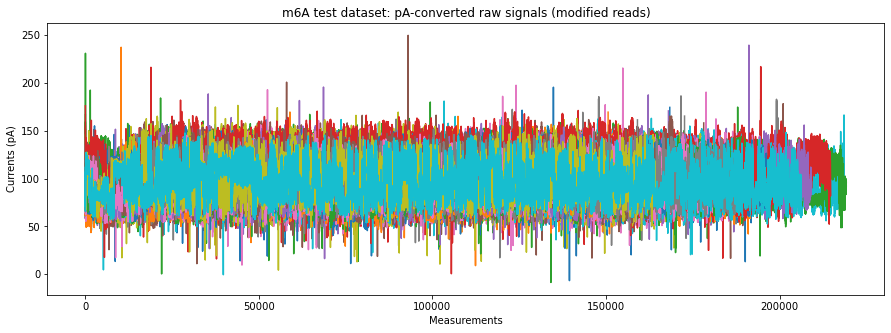

In [53]:
m6A_test_signals.plot(figsize=(15,5), legend=None)
plt.title("m6A test dataset: pA-converted raw signals (modified reads)")
plt.ylabel("Currents (pA)")
plt.xlabel("Measurements")
plt.show()

In [54]:
# Getting all the MAE reconstruction errors computed for the m6A test samples by the model
m6A_test_mae_losses = [] # where are stored the mae losses of m6A test samples.
m6A_test_sum_anomalies = [] # where are stored the cumulative number of anomalies per sample.
m6A_test_anomaly_indices = [] # where are stored the indices of the anomalies with respect the time_step version of the samples
with tqdm(total=len(m6A_test_signals.columns)) as pbar:
    for i in m6A_test_signals.columns:
        m6A_test_mae_loss = get_mae(m6A_test_signals[i], model)
        m6A_test_mae_losses.append(m6A_test_mae_loss)
        anomalies = m6A_test_mae_loss > new_threshold
        sum_anomalies = np.sum(anomalies)
        anomalies_indices = np.where(anomalies)
        m6A_test_sum_anomalies.append(sum_anomalies)
        m6A_test_anomaly_indices.append(anomalies_indices)

        pbar.update(1)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [49:17<00:00, 29.57s/it]


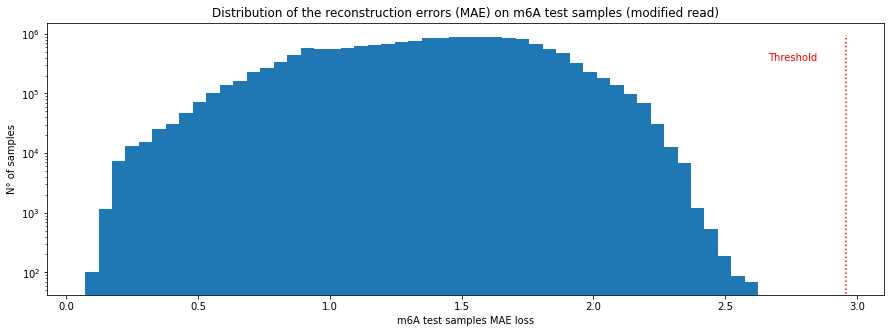

Number of anomaly samples in m6A test reads: 0


In [55]:
plt.figure(figsize=(15,5))
plt.hist(np.concatenate(m6A_test_mae_losses), bins=50)
plt.title("Distribution of the reconstruction errors (MAE) on m6A test samples (modified read)")
plt.vlines(new_threshold, plt.axis()[2], plt.axis()[3], colors="r", linestyles="dotted")
plt.text(new_threshold*0.9, plt.axis()[3]*0.35, "Threshold", c="r")
plt.yscale(value="log")
plt.xlabel("m6A test samples MAE loss")
plt.ylabel("N° of samples")
plt.show()

anomalies_m6A_test = np.concatenate(m6A_test_mae_losses) > new_threshold
print("Number of anomaly samples in m6A test reads:", np.sum(m6A_test_sum_anomalies))

Number of anomalies in m6A_test samples: 0
Percentage of anomalies in m6A_test dataset on total measurements evaluated: 0.0 %

Number of anomalies in X_test samples: 0
Percentage of anomalies in unmodified X_test dataset on total measurements evaluated: 0.0 %



<ipython-input-56-47c67531fa70>:7: RuntimeWarning: invalid value encountered in long_scalars
  np.sum(np.concatenate(m6A_test_mae_losses) > new_threshold) /


m6A_test/X_test anomalies ratio nan


C:\Users\adria\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


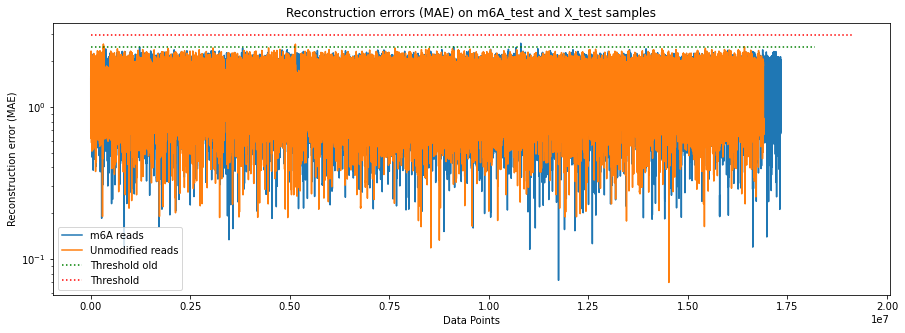

In [56]:
# Results on m6A_test and X_test datasets:
print("Number of anomalies in m6A_test samples:", np.sum(np.concatenate(m6A_test_mae_losses) > new_threshold))
print("Percentage of anomalies in m6A_test dataset on total measurements evaluated:", round(np.sum(np.concatenate(m6A_test_mae_losses) > new_threshold) / np.concatenate(m6A_test_mae_losses).shape[0] * 100, 5), "%\n" )
print("Number of anomalies in X_test samples:", np.sum(np.concatenate(test_mae_losses) > new_threshold))
print("Percentage of anomalies in unmodified X_test dataset on total measurements evaluated:", round(np.sum(np.concatenate(test_mae_losses) > new_threshold) / np.concatenate(test_mae_losses).shape[0] * 100, 5), "%\n" )
print("m6A_test/X_test anomalies ratio", 
        np.sum(np.concatenate(m6A_test_mae_losses) > new_threshold) / 
        np.sum(np.concatenate(test_mae_losses) > new_threshold))

# Compare the Reconstruction MAE of the model in both the datasets with respect the max_threshold value
# computed in the training dataset.
plt.figure(figsize=(15,5))
plt.title("Reconstruction errors (MAE) on m6A_test and X_test samples")
plt.plot(np.concatenate(m6A_test_mae_losses), label="m6A reads", zorder=0)
plt.plot(np.concatenate(test_mae_losses), label="Unmodified reads", zorder=1)
plt.yscale(value="log")
plt.xlabel("Data Points")
plt.ylabel("Reconstruction error (MAE)")
plt.hlines(threshold_max, -1, plt.axis()[1], colors="g", linestyles="dotted", label="Threshold old", zorder=3)
plt.hlines(new_threshold, -1, plt.axis()[1], colors="r", linestyles="dotted", label="Threshold", zorder=4)
plt.legend()
plt.show()